# **Laboratory 5:** Image Compression

Image compression complements the image processing and visual extration steps by optimising the size of your images. This is not only useful for faster computation but also for storage and transmission. In summary, there are two types of image or video compression: lossy and lossless. In the latter, the decompressed image is an exact copy of the original image, while in the former, the original and the decompressed image differ from each other. Lossless compression is needed when the quality of every pixel matters (e.g. in medical data), however, lossy compression is quite useful in images with real-life scenes, where there is plenty of redundancy.

<center>
<img src='https://drive.google.com/uc?id=1NLKPsptd8FOKt-Wk-aiINyje_UazXe-B' width='50%'> </center>

In this lab, you will learn about the principal mappers in compression methods, and you will have to implement the rest of components (quantizers, symbol coders, as well as their counterparts) to design compression pipelines.

## 1. Download an image and import libraries

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.robots.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Shape: (630, 1200)


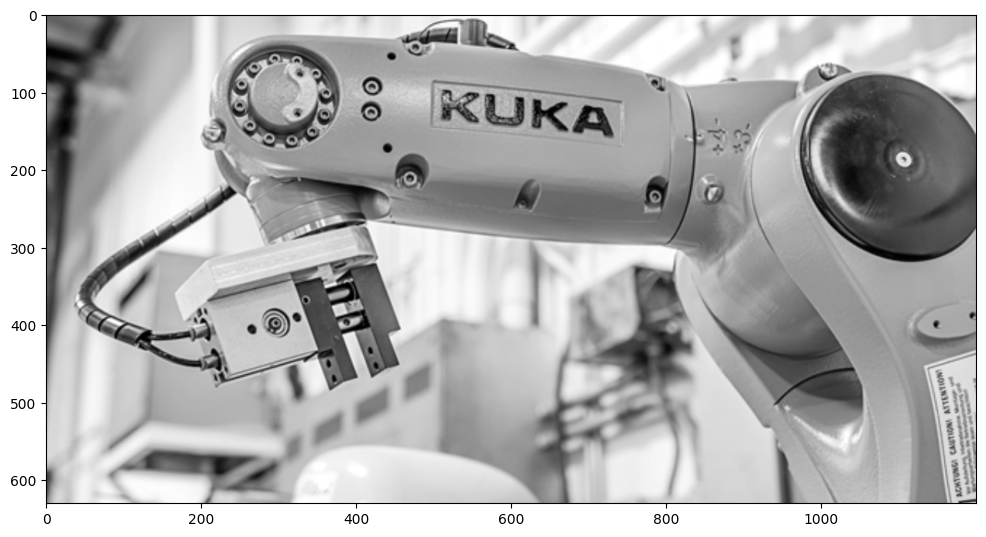

In [ ]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os, requests
import numpy as np
from scipy.fftpack import dct, idct

# Download an image
img_data = requests.get("https://www.robots.com/images/general/_1200x630_crop_center-center_82_none/KUKA_Robot_Small_EOAT.png" , verify=False).content
with open('11209579_431786763660187_2553976445473050475_n.jpg', 'wb') as handler:
    handler.write(img_data)

# Load the image
image = cv2.imread('11209579_431786763660187_2553976445473050475_n.jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to gray Scale
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print("Shape:", grayscale.shape)

plt.figure(figsize=(12,12))
plt.imshow(grayscale, cmap="gray")

## 2. Fast Fourier Transform (Mapper)

Fast Fourier transform is one of the most common mappers in compression methods. The counterside of this method is that it accumulates its energy all over the surface of the resulting image, also known as the magnitude spectrum. This makes the results more difficult to organise and access than the DCT's magnitude spectrums. Therefore, FFT is a bit less used than the DCT transform. In the following cell, you will see that FFT is applied, but note that given that `np.fft.fftshift` and `np.fft.fft2` work with small real and complex values, we apply `20*np.log(np.abs(fshift))` to discretise and rescale these values, such that they become visible for `matplotlib`. This process is only required if you need to visualise intermediate results in the frequency domain.

Fourier output data type:  complex128
Magnitude spectrum data type:  float64


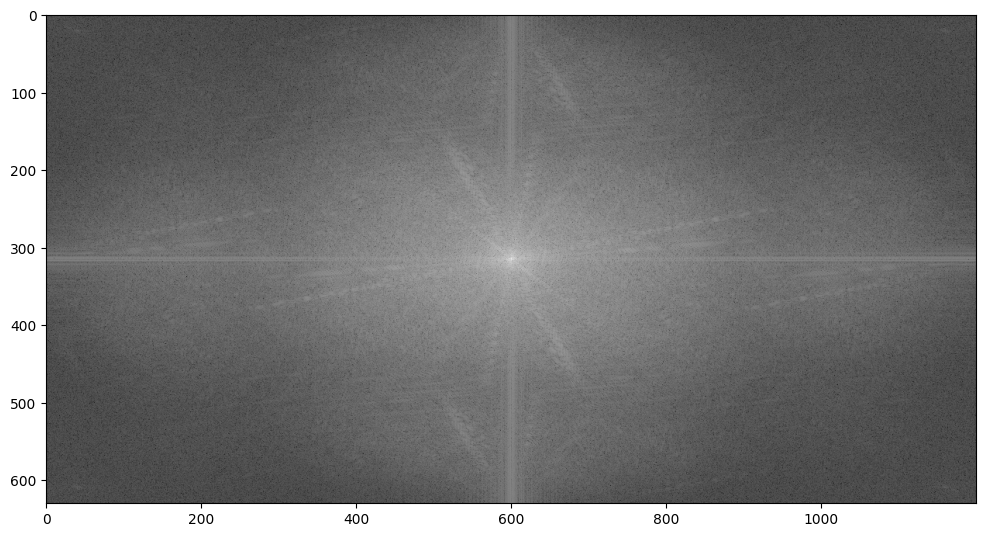

In [ ]:
# Apply Fourier Transform
fourier = np.fft.fft2(grayscale)

# Bring the center to the middle
fshift = np.fft.fftshift(fourier)

print("Fourier output data type: ", fshift.dtype)

# Scale magnitude values
magnitude_spectrum = 20*np.log(np.abs(fshift))

print("Magnitude spectrum data type: ", magnitude_spectrum.dtype)

plt.figure(figsize=(12,12))
plt.imshow(magnitude_spectrum, cmap='gray');

Sorted fourier [7.75827217e-01 7.75827217e-01 1.30269793e+00 ... 7.72622368e+06
 7.72622368e+06 1.25850527e+08]


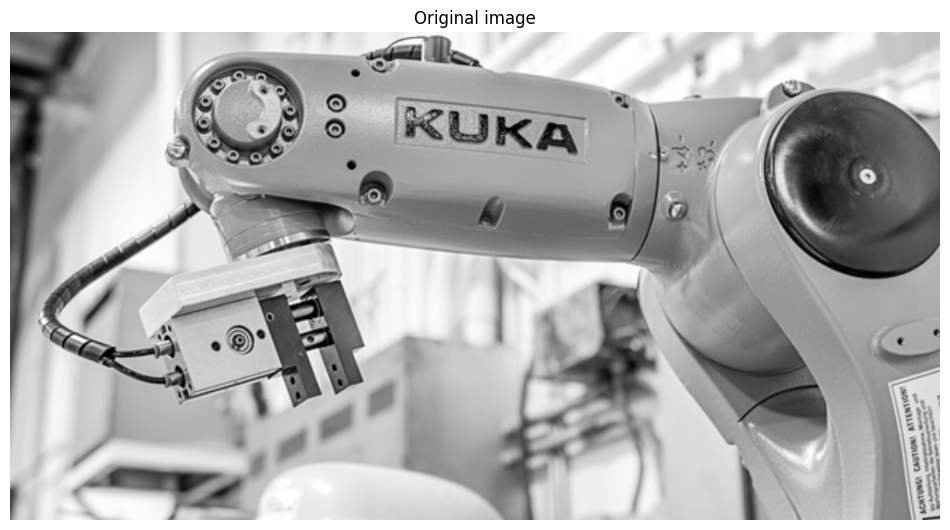

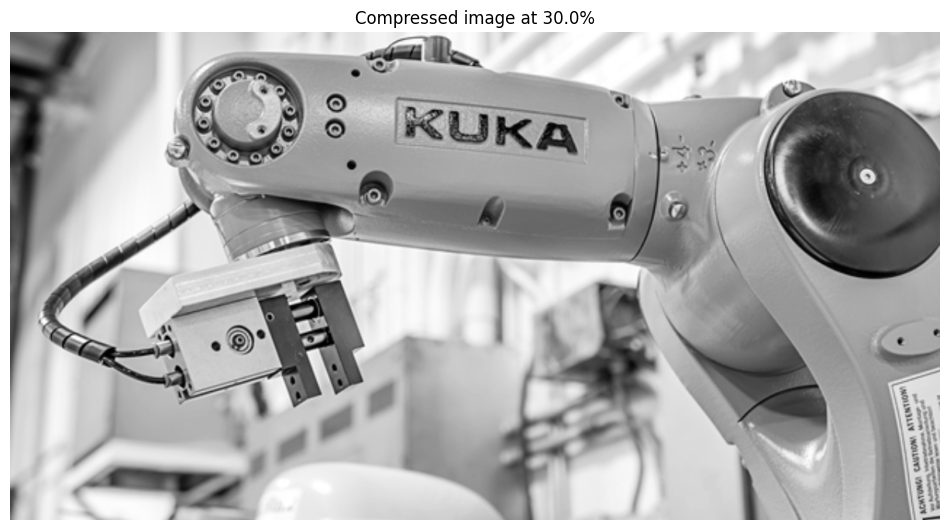

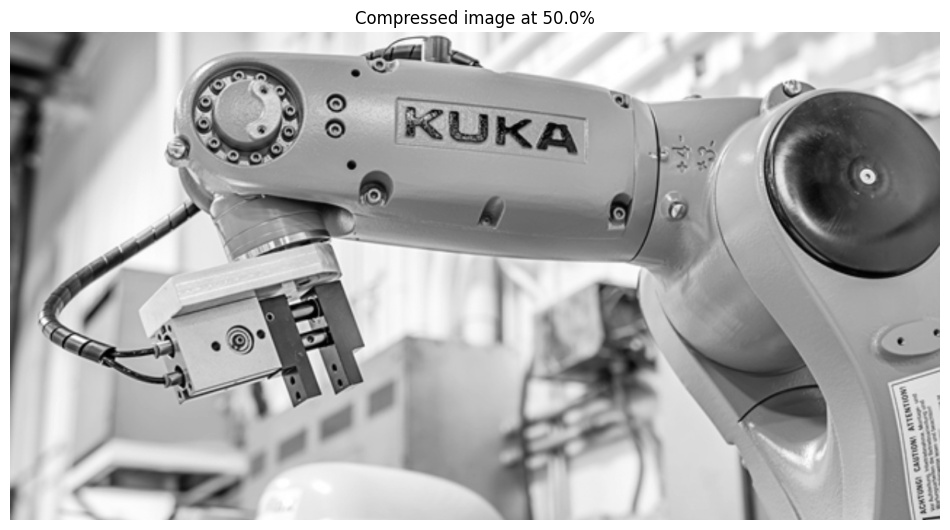

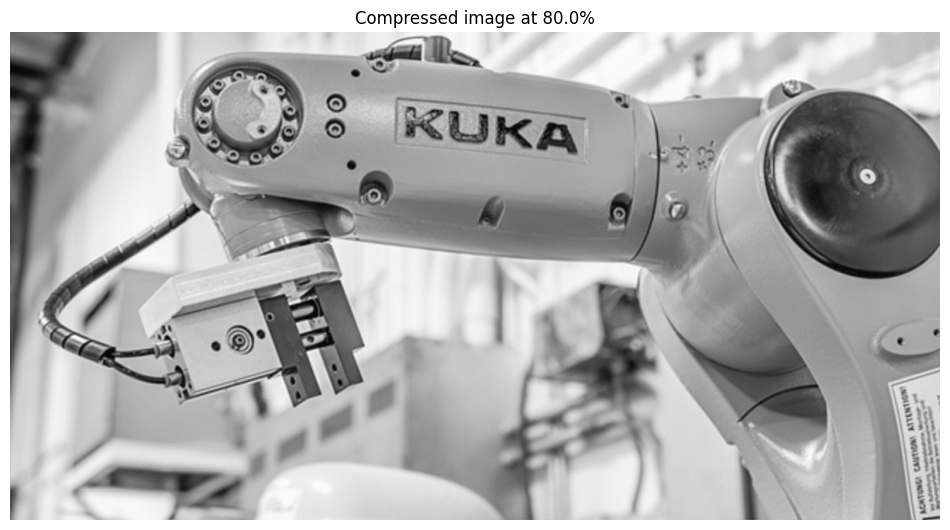

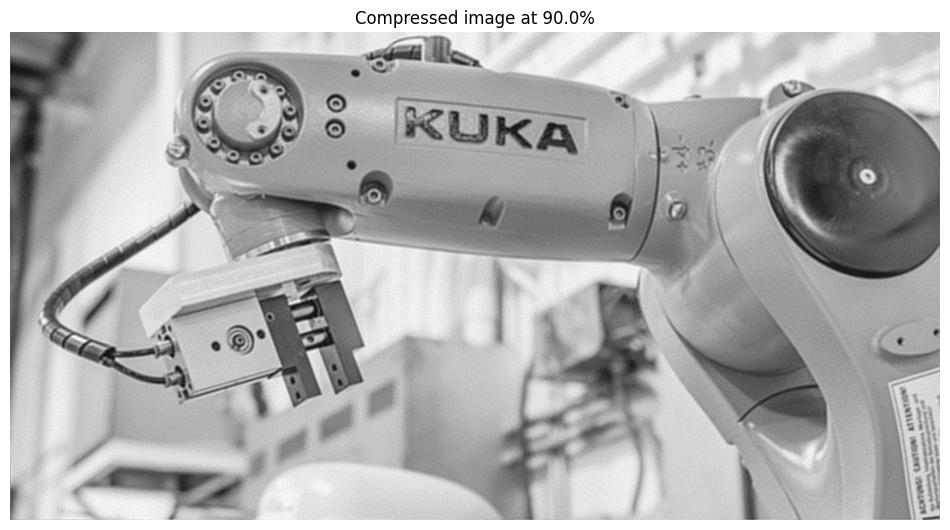

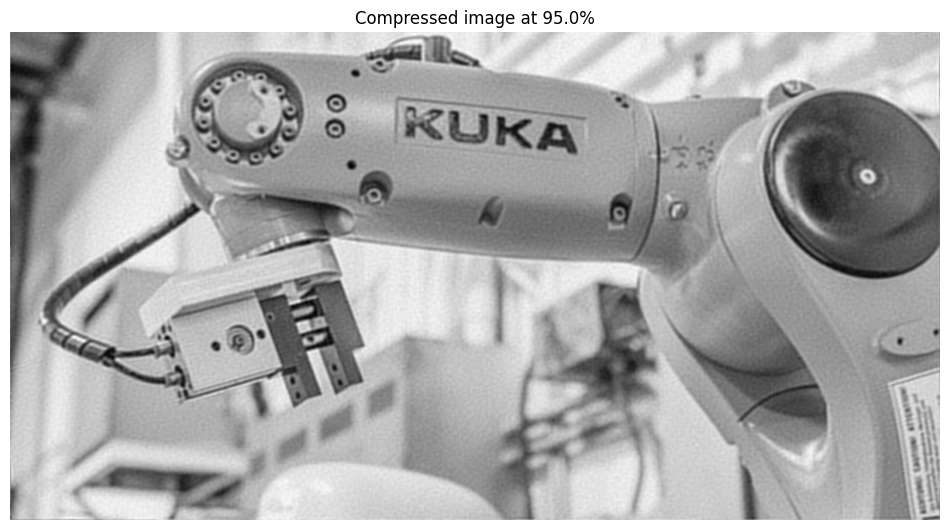

In [ ]:
# Show the original image
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(grayscale, cmap="gray")
plt.title("Original image")

# Convert the magnitude spectrum into a vector and sort fourier values by magnitude
sorted_fourier = np.sort(np.abs(fourier.reshape(-1)))

print("Sorted fourier", sorted_fourier)

compression_percentages = [0.3,0.5,0.8,0.9,0.95]

# Apply a threshold by assigning zero to all small coefficients according to the percentage
for percentage in compression_percentages:
  # Find a threshold value according to the compression percentage
  threshold = sorted_fourier[int(np.floor(percentage*len(sorted_fourier)))]
  # Find smaller values than the threshold. Mark those values as 0 and bigger values as 1.
  mask = np.abs(fourier)>threshold
  # Remove smaller values in the magnitude spectrum
  masked_image = fourier * mask

  compressed_image = np.fft.ifft2(masked_image).real

  plt.figure(figsize=(12,12))
  plt.imshow(compressed_image, cmap="gray")
  plt.axis("off")
  plt.title("Compressed image at "+str(percentage*100)+"%")


## 3. Discrete Cosine Transform (Mapper)

Discrete Cosine Transform is one of the most used mappers because it concentrates its energy on a specific region (the top left section) in the resulting magnitude spectrum. This feature makes it easy to compress information by removing ceros or repetitive values in the rest of its magnitude spectrum. Consequently, DCT was chosen to form part of the JPEG compression algorithm. Although OpenCV has a DCT implementation, Scipy library's fftpack module has also proven to be very efficient with this transform. Let's prove DCT in the entire image first.

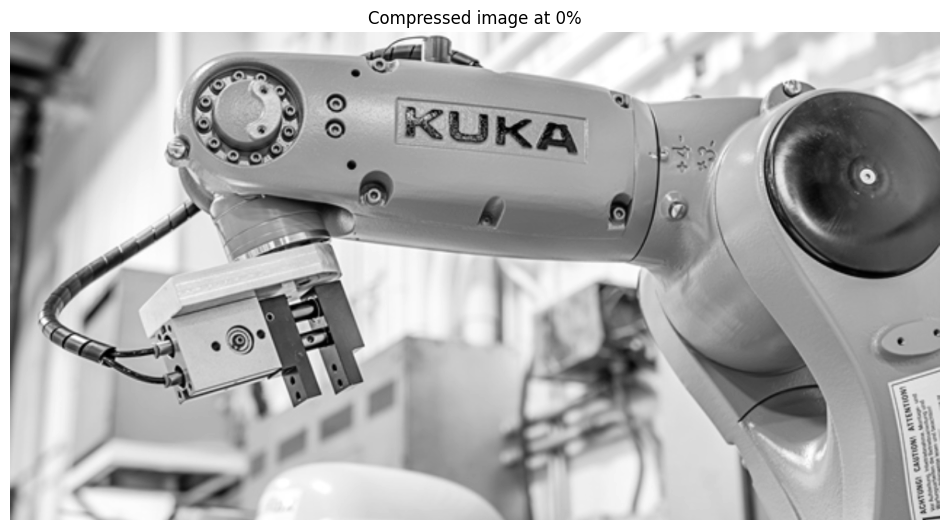

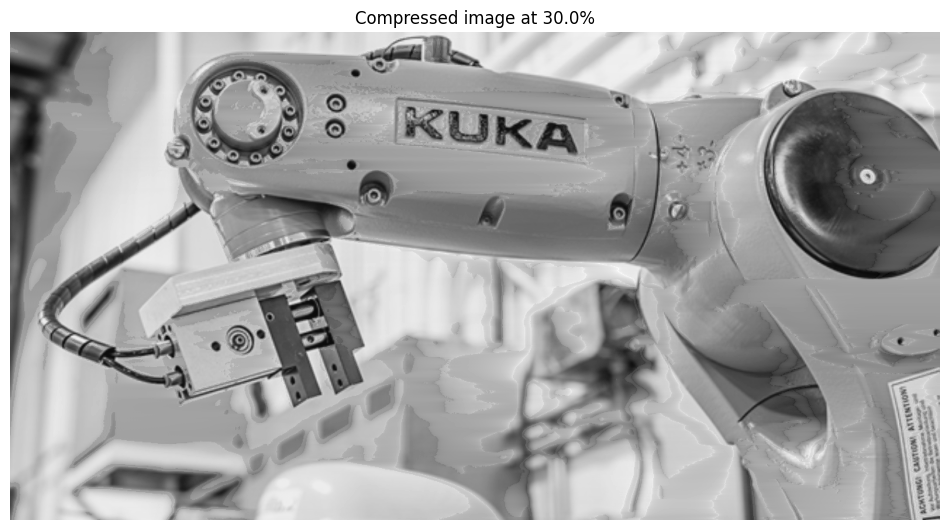

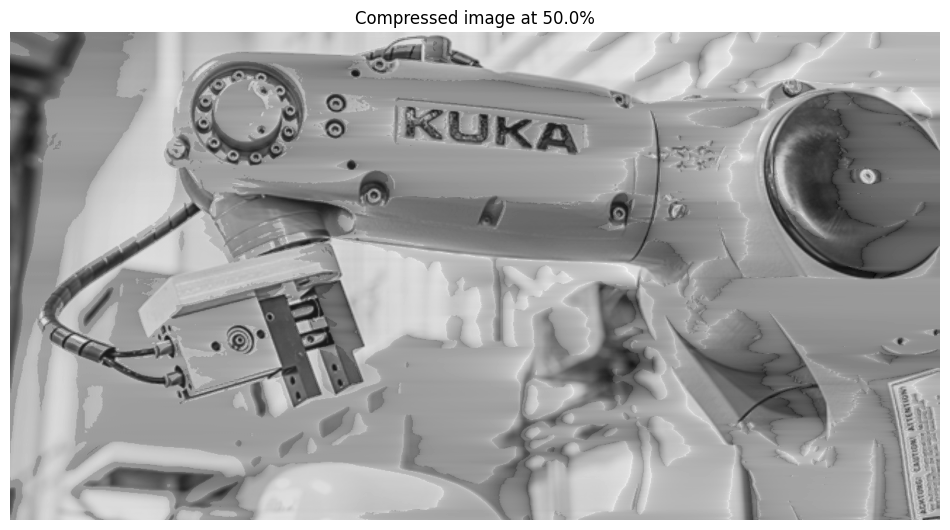

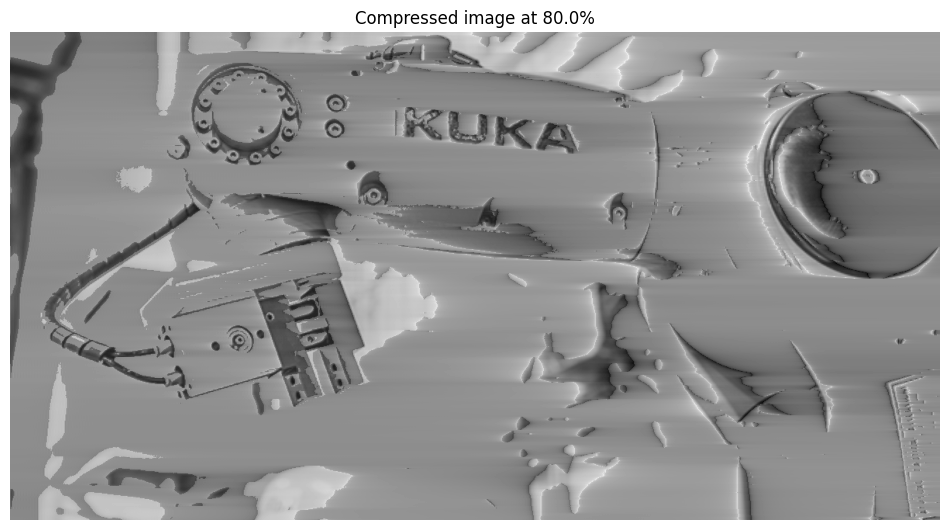

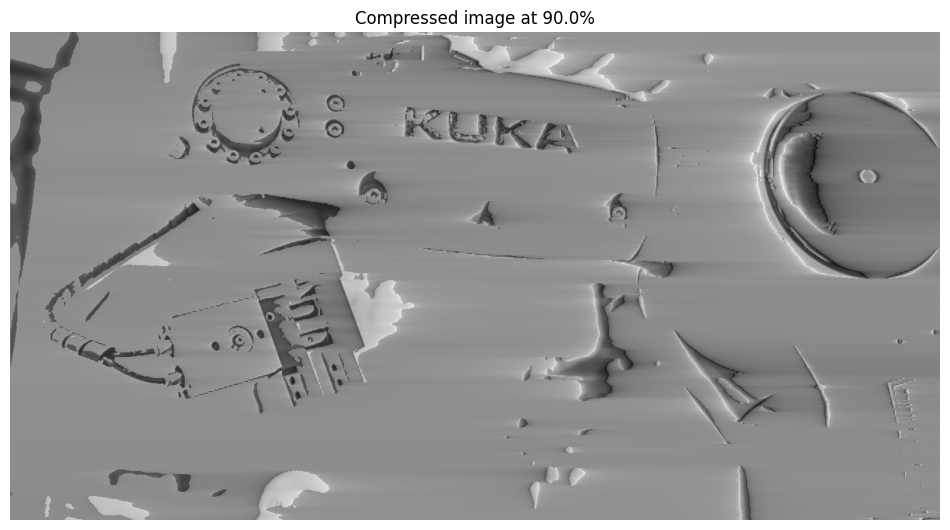

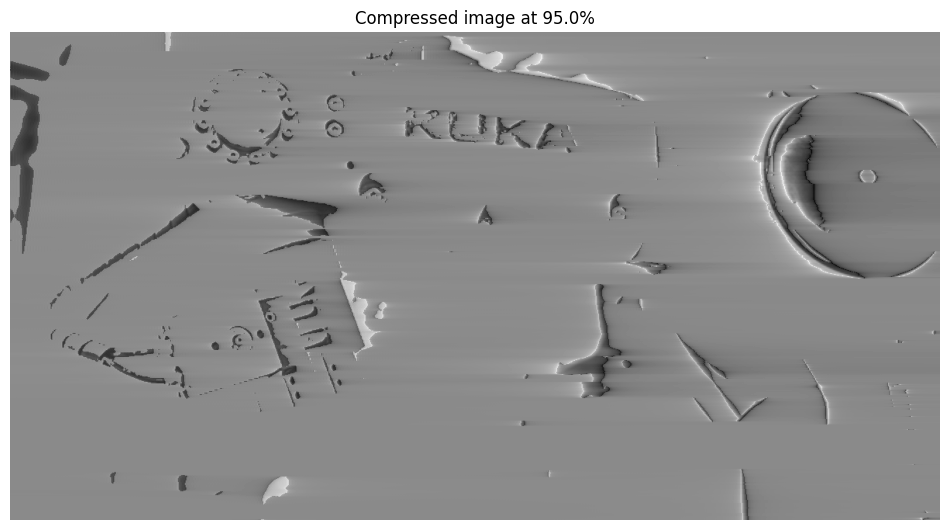

In [ ]:
# Implement 2D DCT
def dct2(image):
    return dct(dct(image.T, axis=0, norm='ortho').T, axis=1, norm='ortho')

# Implement 2D Inverse DCT
def idct2(image):
    return idct(idct(image.T, axis=0, norm='ortho').T, axis=1, norm='ortho')

# Normalize the image. This time we will work with YUV to compress only the luminance channel
gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
new_gray_image = (gray_image-np.mean(gray_image))/np.std(gray_image)
# print(np.amin(y), np.amax(y))

# Initialize a base image
new_dct = dct2(new_gray_image)

# Convert the magnitude spectrum into a vector and sort dct values by magnitude
sorted_dct = np.sort(np.abs(new_dct.reshape(-1)))

compression_percentages = [0, 0.3,0.5,0.8,0.9,0.95]

# Apply a threshold by assigning zero to all small coefficients according to the percentage
for percentage in compression_percentages:
  # Find a threshold value according to the compression percentage
  threshold = sorted_dct[int(np.floor(percentage*len(sorted_dct)))]
  # Find smaller values than the threshold. Mark those values as 0 and bigger values as 1.
  mask = np.abs(new_dct)>threshold
  # Remove smaller values in the magnitude spectrum
  masked_image = new_dct * mask

  compressed_y = idct2(masked_image).real

  # Denormalize values
  returned_gray = (compressed_y+np.mean(compressed_y))*np.std(compressed_y)

  plt.figure(figsize=(12,12))
  plt.imshow(returned_gray, cmap="gray")
  plt.axis("off")
  plt.title("Compressed image at "+str(percentage*100)+"%")


Similar to what happened with magnitude spectrum images coming from FFT, understanding the content of DCT's magnitude spectrum is challenging for us. However, bear in mind that both FFT and DCT aim to remove redundancy in images. In practice, the JPEG format relies on small Discrete Cosine Transforms, computed on local and normalized square patches of size 8x8, therefore, let's divide the image and apply DCT to every patch.

-3.005856237957821 1.5985660029876516


<ipython-input-28-0a2f6a50263a>:24: RuntimeWarning: invalid value encountered in divide
  aux = (aux-np.mean(aux))/np.std(aux)
<ipython-input-28-0a2f6a50263a>:29: RuntimeWarning: divide by zero encountered in log
  dct_vis = 20*np.log(np.abs(new_dct))


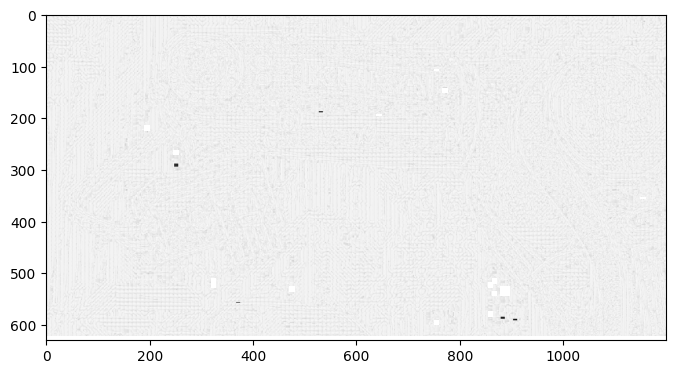

In [ ]:
from scipy.fftpack import dct, idct

# Implement 2D DCT
def dct2(image):
    return dct(dct(image.T, axis=0, norm='ortho').T, axis=1, norm='ortho')

# Implement 2D Inverse DCT
def idct2(image):
    return idct(idct(image.T, axis=0, norm='ortho').T, axis=1, norm='ortho')

# Normalize the image
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grayscale = (grayscale-np.mean(grayscale))/np.std(grayscale)
print(np.amin(grayscale), np.amax(grayscale))

# Initialize a base image
new_dct = np.zeros(grayscale.shape)

# Loop over small patches (8x8)
for row in range(1,grayscale.shape[0]//8+1):
  for col in range(1,grayscale.shape[1]//8+1):
    # Create an 8x8 segment
    aux = grayscale[(row-1)*8: row*8, (col-1)*8: col*8]
    aux = (aux-np.mean(aux))/np.std(aux)
    # Apply DCT to segment and save it
    new_dct[(row-1)*8: row*8, (col-1)*8: col*8] = dct2(aux)

# Scale magnitude values and display
dct_vis = 20*np.log(np.abs(new_dct))

plt.figure(figsize=(8,8))
plt.imshow(dct_vis, cmap="gray");


As explained in class, each 8x8 cell will require to be processed separately for the JPEG following steps.

## 4. Principal Compontent Analysis (Mapper)

The fundamental objective of PCA is to reduce dimensionality in a dataset. However, this approach can also be implemented in image compression. PCA uses orthogonal transformations to convert a set of data rows with possibly correlated variables into a set of data rows of linearly uncorrelated variables called **principal components**. These are meant to represent (or "summarise") the original dataset with less variables, which are selected by their eigenvalues and eigenvectors. Let's implement it into the previous image

In [ ]:
# The PCA module in Sklearn is the most known implementation of PCA.
from sklearn.decomposition import PCA

# First, let's define the number of principal components
components = 50

# Initialize PCA
pca = PCA(n_components=components)

# Standardize the data, so all instances have 0 as the center. Then, learns some
# quantities from the data, most importantly the "principal axes (vectors)" and the "explained variance"
pca.fit(grayscale)

# Important note: PCA obtains all the principal vectors by default in the components_ variable.
# Then, you can use the .transform() function to obtain uniquely the number of images defined when creating
# the object pca (50 in this case.)
print("Components", pca.components_[:10])

# PCA.transform also finds the explained_variance_ratio_ ,
# which shows the % of variance explained by each component
print("Explained variance", pca.explained_variance_[:10])

Components [[-0.01201586 -0.01223037 -0.01260048 ... -0.03305212 -0.03293359
  -0.03286515]
 [ 0.01229091  0.01411535  0.01732327 ...  0.00428636  0.00243476
   0.00136374]
 [-0.04691002 -0.04870746 -0.0519154  ...  0.01308991  0.01360048
   0.01392467]
 ...
 [-0.02596927 -0.02657697 -0.02768976 ... -0.03011547 -0.03948668
  -0.04482091]
 [ 0.03339753  0.03308519  0.03258679 ...  0.04007401  0.03696658
   0.03527807]
 [ 0.01512583  0.01473807  0.01403348 ...  0.01369475  0.00206641
  -0.0046    ]]
Explained variance [290.40651238 159.95286562 116.25198404  75.37715381  43.06977154
  42.06759427  38.61659602  28.93323205  21.16713564  19.84683889]


Original shape:    (630, 1200)
Transformed shape: (630, 50)


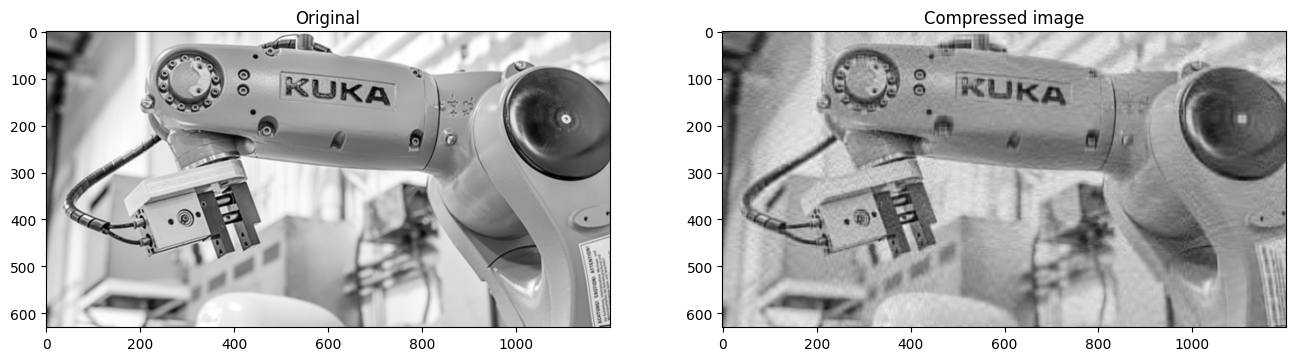

In [ ]:
# Project all raws to the (principal axes), find the principal components and remove the least important ones
# Theres's also another function that joins fit and tranform: pca.Fit_transform()
grayscale_pca = pca.transform(grayscale)

print("Original shape:   ", grayscale.shape)
print("Transformed shape:", grayscale_pca.shape)

# The transformed data has been reduced to a lower dimension meaning
# that the image only has 25 colummns in this case

# Since PCA reduces the number of columns, we will need to transform the results
# to the original space to display the compressed image
new_grayscale = pca.inverse_transform(grayscale_pca)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.set_title('Original')
ax1.imshow(grayscale, cmap='gray')

ax2.set_title('Compressed image')
ax2.imshow(new_grayscale, cmap='gray')

As you can see, transforming the image from the 1200th dimension to the 50th dimension and then reprojecting the data onto the principal components to obtain the original 1200 columns cause loss of data. Now, let's apply the method for all the channels:

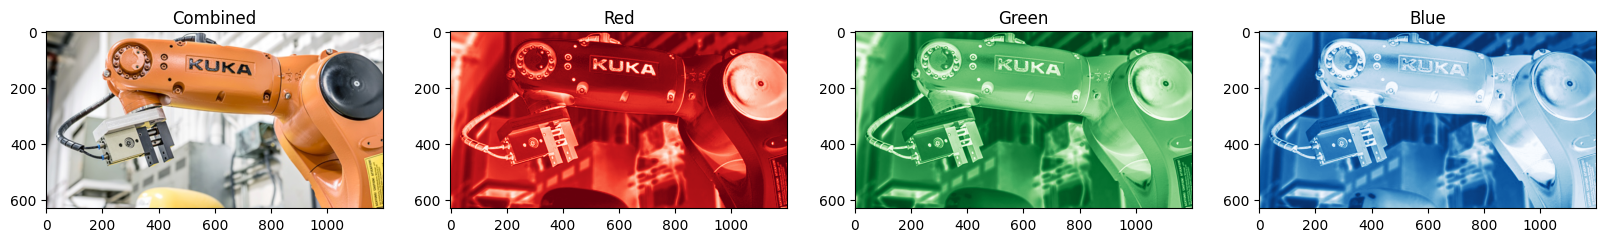

In [ ]:
# Load the image
image = cv2.imread('11209579_431786763660187_2553976445473050475_n.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# RGB channels
r = image_rgb[:,:,0]
g = image_rgb[:,:,1]
b = image_rgb[:,:,2]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))

ax1.set_title('Combined')
ax1.imshow(image_rgb)

ax2.set_title('Red')
ax2.imshow(r, cmap="Reds")

ax3.set_title('Green')
ax3.imshow(g, cmap="Greens")

ax4.set_title('Blue')
ax4.imshow(b, cmap="Blues")

Implement PCA on each colour channel

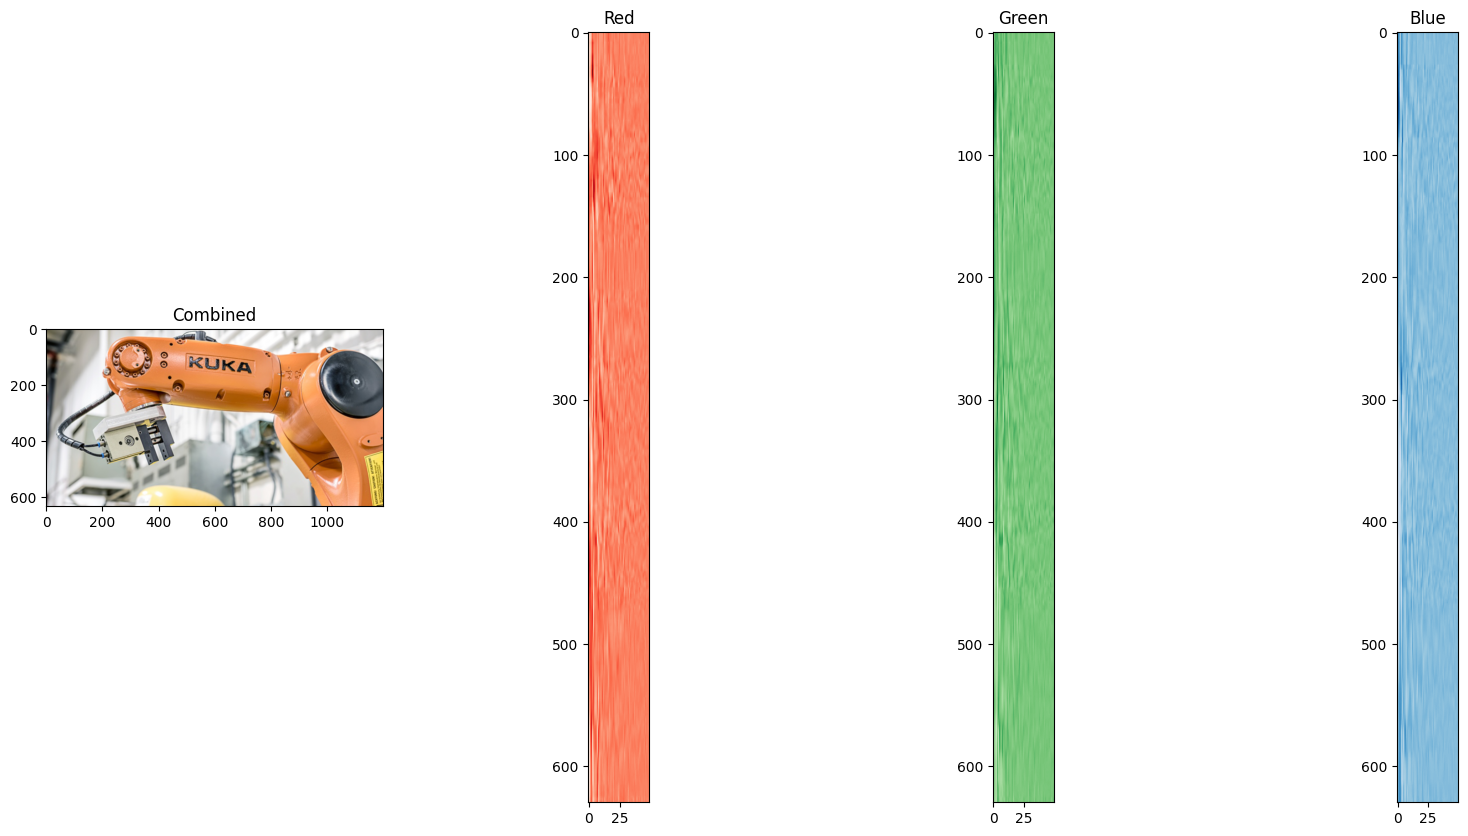

In [ ]:
channels = [r,g,b]

res = []

for channel in range(3):
    # PCA
    pca = PCA(n_components = 50)
    pca.fit(channels[channel])
    channel_pca = pca.transform(channels[channel])

    pca_dict = {"projections": channel_pca,
                "components": pca.components_,
                "explained_variance":pca.explained_variance_ratio_,
                "pca_object":pca
                }

    res.append(pca_dict)

# Visualize the principal components of each colour channel
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))

ax1.set_title('Combined')
ax1.imshow(image_rgb)

ax2.set_title('Red')
ax2.imshow(res[0]["projections"], cmap="Reds")

ax3.set_title('Green')
ax3.imshow(res[1]["projections"], cmap="Greens")

ax4.set_title('Blue')
ax4.imshow(res[2]["projections"], cmap="Blues");

We can also check the *explained variance ratio* (EVR) for each principal component obtained in the previous step. As stated before in class, PCA obtains the eigen vectors and values that depicts the original dataset, which in turn means we could retrieve the original dataset only by using the inverse of the pca transformation and the `pca.components_` variable. Moreover, EVR of each principal component defines the contribution of them to represent the original dataset. Note that the higher the eigen value, the more the contribution to represent the original dataset.

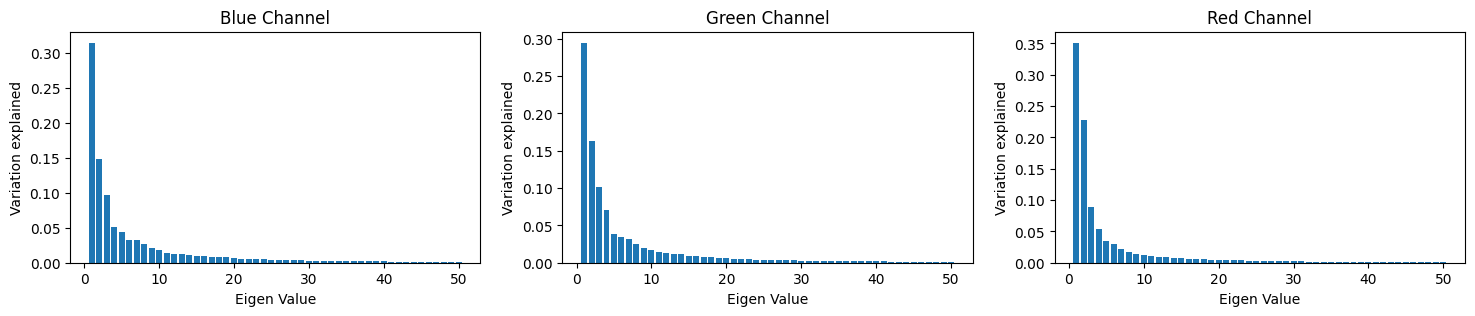

In [ ]:
fig = plt.figure(figsize = (18, 3))
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,len(res[0]["components"])+1)),res[0]["explained_variance"])

fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,len(res[1]["components"])+1)),res[1]["explained_variance"])

fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,len(res[2]["components"])+1)),res[2]["explained_variance"])
plt.show()

Now, let's the example by combining the channels. First, we need to apply the inverse transform function to reproject the 50 principal components to the 1200th dimensions since this was the original width of the image. Although this step can be mathematically strenuous, the PCA implementation of scikitlearn has the inverse_transform function to help us with this procedure.

In [ ]:
r_arr = res[0]["pca_object"].inverse_transform(res[0]["projections"])
g_arr = res[1]["pca_object"].inverse_transform(res[1]["projections"])
b_arr = res[2]["pca_object"].inverse_transform(res[2]["projections"])

In [ ]:
img_reduced = cv2.merge((r_arr, g_arr, b_arr))

# Convert values to uint8 to improve the visualisation
img_reduced = img_reduced.astype(np.uint8)

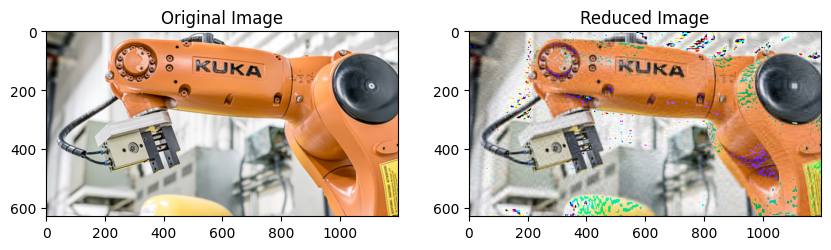

In [ ]:
fig = plt.figure(figsize = (10, 7.2))
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(image_rgb)

fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced);

### **Exercise 1:** JPEG with Different Mappers
For this exercise, you have to create a function to apply the JPEG algorithm using DCT, FFT, and PCA as mappers. Implement a quantizer and a symbol encoder according to the original JPEG steps explained in class. Your function should only process images in grayscale and ask for a compression level as parameter. Then, you can use `cv2.cvtColor()` to ease your work coding with one channel. Also, note that JPEG compresses images by splitting them into 8x8 sections.  

Then, answer the following questions:
- Which mapper improves JPEG and gets the most effective memory usage?
- Which mapper improves JPEG and requires the shortest possible time?
- Show a comparison table to answer both questions by testing your function with different compression levels.

**Note 1:** Try to save a binary file using the built-in `open function` instead of applying the `cv.imwrite` function. This is because `cv.imwrite` has its own set of embedded compression algorithms that might change your results. You can use the following example:

```
with open('image.jpeg', 'w') as file:
      
    codes = ['321\n',
             '123\n',
             '321\n']
      
    file.writelines("%s\n"%code for code in codes)
```

**Note 2:** You can use the built-in library time to measure the execution time of an algorithm. Consider the following example:

```
import time
start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))
```

### **Exercise 2:** Dealing with Colour Images

Since the previous exercise was implemented with grayscale images, you will now have to extend your function to deal with colour images. Your method should adapt according to the input image, e.g. work with three channels if the input images is in RGB.

**Note 1:** Consider to search and use a suitable set of huffman tables.

**Note 2:** While you implement this method, it's likely you will find variations of the JPEG stages explained in class. This time, you must implement the JPEG algorithm version explained in class and make changes if necessary, detailing  the changes you make.

### **Exercise 3:** Decompressing JPEG images

Implement a decompression function and validate that your method is able to compress and uncompress colour images by showing two samples. Note that your method should require any necessary element as parameter to complete the decompression process. (e.g. the pca object that you used to fit the subsegment, huffman tables, etc.). Even though you can embed these elements inside the compressed file, it will easier to save those elements inside separate files.

### **Exercise 4:** Delta encoding

Implement delta coding into your JPEG algorithm and measure the size and time of compressing an image. Create a table to show the previous and new results.  

### **Exercise 5:** Working with datasets
For this exercise, you will have to use the functions created previously to compress the images inside this [dataset](https://drive.google.com/file/d/1kpiSyUeyhNgAaGCZoIZO6Fxp4FUtdP2p/view?usp=sharing). This time, you will have to use the best mapper obtained in Exercise 1 and 2, and compress it. It won't be necessary to compress other types of files. After finishing the compression, you will have to create a new zip folder, for which you can use the `shutil.make_archive()` function.  

Most importantly, compare the required time and size of producing the new zip folders when using 0.20%, 0.40%, 0.60%, 0.60%, 0.80, and 0.90% and percentage levels.



## Bibliography

- [The Discrete Cosine Transform](https://cs.stanford.edu/people/eroberts/courses/soco/projects/data-compression/lossy/jpeg/dct.htm#:~:text=The%20DCT%20can%20be%20used,as%20a%20three%2Ddimensional%20signal.), Stanford University
- [A One-Stop Shop for Principal Component Analysis](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c), Medium